# Tuft processing

Having processed the wing image to obtain tuft sub-images, we are now interested in processing these sub-images delicately to obtain 0-1 matrices usable by our chosen machine learning technique.

In [1]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from scipy import ndimage
from scipy.signal import convolve2d
from PIL import Image

from tuft_helpers import *

In [2]:
# Load the processed data into pandas
tufts_df = load_df('im0007')

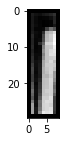

In [3]:
# Check to see that tuft images are correctly loaded

import random as rand
from basic import rescale_image

i = rand.randint(0, len(tufts_df['tuft']) - 1)

img = np.array(tufts_df.iloc[i]['tuft'])

plt.figure(figsize=(2, 2))
plt.imshow(rescale_image(img), cmap='gray')

We observe that the tufts we seek to extract and process are always attached to the bottom of the image. Our first approach to isolating the tuft is the following:
- Find the brightest pixel close to the center on the bottom-most row of the image (taking into account the black border).
- From this pixel, construct a blob such that all pixels have similar brightness values (the difference between two adjacent blobs does not exceed a threshold value $delta$)
- The blob constitutes the tuft. All its pixels are to be colored white (set to 1), and all other pixels in the image are to be colored black (set to 0).

In [4]:
def mid_generator(width):
    mid = int(np.floor(width / 2))
    lo = list(range(mid))
    lo.reverse()
    hi = list(range(mid, width))

    i = 0
    while (lo or hi):
        i = (i + 1) % 2
        if (i == 0):
            y = lo[0]
            lo = lo[1:]
        else:
            y = hi[0]
            hi = hi[1:]

        yield y

In [5]:
def get_lower_brightest_pixel(img, bg_threshold):

    for i in range(img.shape[0] - 1).__reversed__():
        width = len(img[i])
        for j in mid_generator(width):
            if (img[i, j] > bg_threshold):
                return (i, j)

    return None


In [6]:
start_pixel = get_lower_brightest_pixel(img, 0.2)
print(start_pixel)

(28, 4)


In [7]:
from blobs import get_blob_pixels, coordinates_within_bounds, index_set

In [8]:
sim_delta = 0.025

def pixel_is_similar(img, cur_, next_):
    """
    Check that the next pixel is within image
    boundaries and has a value similar enough to
    the current pixel.
    """
    return coordinates_within_bounds(img, cur_, next_)\
           and (np.abs(img[cur_] - img[next_]) <= sim_delta)

In [9]:
main_blob = get_blob_pixels(img, start_pixel, pixel_is_similar, set())


idx = index_set(main_blob)


result_img = np.zeros(shape=img.shape)
result_img[idx] = 1

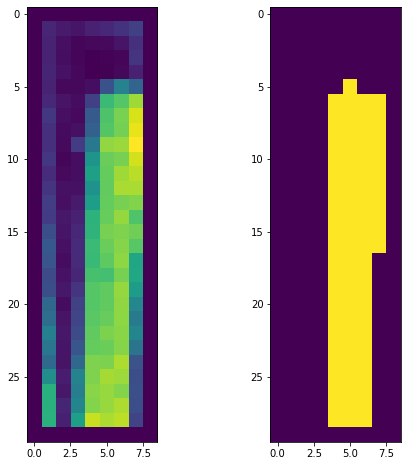

In [10]:
imgs = [img, result_img]

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i - 1])
plt.show()


In [11]:
def tuft_pipeline(img):
    start_pixel = get_lower_brightest_pixel(img, 0.2)

    main_blob = get_blob_pixels(img, start_pixel, pixel_is_similar, set())

    idx = index_set(main_blob)

    result_img = np.zeros(shape=img.shape)
    result_img[idx] = 1

    return result_img

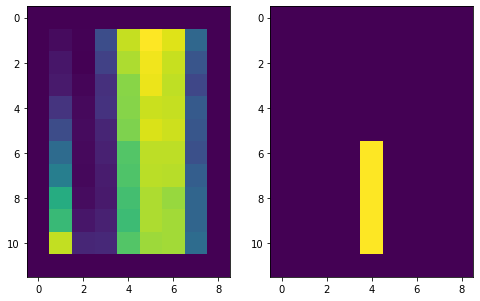

In [58]:
import random as rand
from basic import rescale_image

i = rand.randint(0, len(tufts_df['tuft']) - 1)

img = np.array(tufts_df.iloc[i]['tuft'])
result_img = tuft_pipeline(img)

imgs = [img, result_img]

w = 10
h = 10
fig = plt.figure(figsize=(8, 8))
columns = 2
rows = 1
for i in range(1, columns*rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i - 1])
plt.show()
